<div style="text-align:center; font-size:2.5em; color:#4B0055; letter-spacing:2px; background-color:#F5F5F5; padding:20px; border-radius:10px; width: 97%">
    Modelo e Análise Exploratória de Dados: 
    <span style="color:#FFA726; font-weight:bold;">Fluxar</span>
    <div style="text-align:center; margin-top:10px;">
        <img src="logo_fluxar.png" alt="Logo Fluxar" style="height:70px;">
    </div>
</div>


<div style="background:#F7F3FF; border-left:8px solid #4B0055; padding:16px; margin-top:20px; width: 97%">
    <span style="font-size:1.3em; color:#4B0055; font-weight:bold;">Modelo escolhido:</span><br>
    <span style="color:#FFA726; font-size:1.1em;">Forecasting & Stockout Prediction — <b>Fluxar</b></span>
</div>


<div style="background:linear-gradient(90deg, #ffc164ff 0%, #FF1493 100%); color:white; padding:18px; border-radius:10px; margin-top:20px;width: 97%">
    <span style="font-size:1.2em; font-weight:bold;">Objetivos Concretos do Modelo Fluxar:</span>
    <ul style="margin-top:10px;">
        <li>Prever o número de dias até o estoque acabar (<i>days_to_stockout</i>) para cada SKU, com horizonte de previsão de 14 dias.</li>
        <li>Permitir que o gestor se antecipe antes que o produto falte.</li>
        <li>Reduzir a ocorrência de <b>stockouts</b> em pelo menos <span>20%</span> (meta inicial), evitando perdas de vendas e desperdício logístico.</li>
        <li>Gerar alertas automáticos no app (push notification) quando o estoque projetado atingir níveis críticos.</li>
        <li>Fornecer insights de tendência, por exemplo: quais SKUs frequentemente entram em risco de <i>stockout</i>.</li>
    </ul>
</div>

### <span style="color:#4B0055; font-family:'Segoe UI', 'Arial', sans-serif;">Importação de Bibliotecas</span>

In [25]:
# Para manipulação de arquivos e sistema
import os
import time
import joblib
import redis

# Para o dataset
import pandas as pd
import numpy as np
import kagglehub
import shutil

# Para análise e visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Para pré-processamento e transformação de dados
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

# Para dividir dados e buscar hiperparâmetros
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit

# Para modelos
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Para avaliação de modelos
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Para salvar no Redis
import io

### <span style="color:#4B0055; font-family:'Segoe UI', 'Arial', sans-serif;">Construção de pipeline de criação de ML </span>

<!-- Etapa 1 -->
<div style="background:#F7F3FF; border-left:8px solid #FFA726; padding:18px; border-radius:10px; margin-top:24px; width: 97%">
  <span style="font-size:1.2em; color:#4B0055; font-weight:bold;">1. Definição do Problema</span>
  <p style="color:#4B0055;">
    <b>Objetivo:</b> Prever o número de dias até o estoque acabar (<em>days_to_stockout</em>) para cada SKU/loja, com horizonte de previsão de 14 dias.<br>
    <b>Tipo de problema:</b> Regressão, pois a saída é uma variável contínua.<br>
    <b>Metas concretas:</b> Reduzir <em>stockouts</em>, gerar alertas automáticos e antecipar a reposição.
  </p>
</div>

In [26]:
print("Etapa 1 concluída: Problema definido")

Etapa 1 concluída: Problema definido


<!-- Etapa 2 -->
<div style="background:#F7F3FF; border-left:8px solid #FFA726; padding:18px; border-radius:10px; margin-top:24px; width: 97%">
  <span style="font-size:1.2em; color:#4B0055; font-weight:bold;">2. Coleta de Dados</span>
  <p style="color:#4B0055;">
    <b>Dataset:</b> <em>Retail Store Inventory Forecasting</em> (Kaggle)<br>
    <b>Conteúdo:</b> dados históricos diários de estoque, vendas, promoções, feriados, clima, preços e categorias de produto.<br>
    <b>Objetivo:</b> garantir histórico suficiente por SKU e loja para treinar modelos robustos.
  <hr style="color: #FFA726">
  <p style="color:#4B0055;">
    O dataset utilizado no modelo é o <em>Retail Store Inventory Forecasting</em>, disponível no Kaggle.<br><br>
    Ele foi escolhido por representar de forma realista e completa a dinâmica de <b>estoques em redes de varejo</b>,
    possuindo dados históricos diários de múltiplos produtos e unidades, incluindo variáveis como:
  </p>
  <ul style="color:#4B0055; margin-top:10px;">
    <li><b>Store_ID</b> e <b>Product_ID</b>: equivalentes às entidades <em>unidade</em> e <em>produto</em> do banco Fluxar.</li>
    <li><b>Inventory_Level</b> e <b>Units_Sold</b>: usados para calcular o alvo <code>days_to_stockout</code>.</li>
    <li><b>Date</b>: registros diários que permitem o uso de janelas temporais e médias móveis.</li>
    <li><b>Category</b> e <b>Region</b>: podem ser associados a <em>setores</em> e <em>localizações</em> das unidades.</li>
    <li><b>Weather_Condition</b> e <b>Holiday/Promotion</b>: fatores externos que enriquecem o modelo preditivo.</li>
  </ul>
  <p style="color:#4B0055; margin-top:10px;">
    A estrutura temporal, a granularidade por produto e loja, e a presença de variáveis contextuais tornam este
    <b>o dataset ideal</b> para simular o comportamento de estoques industriais no Fluxar, permitindo o desenvolvimento
    e a validação do modelo de regressão de forma fiel ao cenário real.
  </p>
</div>

In [27]:
# Caminho final desejado
destino = r"C:\Users\mayumishimizu-ieg\OneDrive - Instituto Germinare\Área de Trabalho\2º ANO\Interdisciplinar\Modelo"
destino_dataset = os.path.join(destino, "dataset_fluxar")
os.makedirs(destino_dataset, exist_ok=True)

# Baixar dataset do Kaggle
try:
    path = kagglehub.dataset_download("anirudhchauhan/retail-store-inventory-forecasting-dataset")
    if os.path.exists(path):
        print("✅ | Dataset baixado em:", path)
    else:
        raise FileNotFoundError("Caminho do download não existe.")
except Exception as e:
    print("❌ | Erro ao baixar dataset:", e)
    path = None

# Copiar e renomear o primeiro CSV encontrado para "dataset_modelo.csv"
if path:
    for file in os.listdir(path):
        full_file_path = os.path.join(path, file)
        if os.path.isfile(full_file_path) and file.endswith(".csv"):
            destino_final = os.path.join(destino_dataset, "dataset_modelo.csv")
            try:
                shutil.copy(full_file_path, destino_final)
                print(f"✅ | Arquivo salvo e renomeado como: {destino_final}")
            except Exception as e:
                print("❌ | Erro ao copiar o arquivo:", e)
            break  # garante que só salva o primeiro CSV

# Verificação rápida
try:
    df = pd.read_csv(os.path.join(destino_dataset, "dataset_modelo.csv"))
    print(f"\n✅ | dataset_modelo.csv carregado com sucesso!")
    print(f"Dimensão: {df.shape}\n")
    display(df.head().style.set_table_styles(
        [{'selector': 'th', 'props': [('background-color', '#FFA726'), ('color', 'white')]},
         {'selector': 'td', 'props': [('padding', '5px')]}]
    ))
except Exception as e:
    print("❌ | Erro ao carregar CSV:", e)

✅ | Dataset baixado em: C:\Users\mayumishimizu-ieg\.cache\kagglehub\datasets\anirudhchauhan\retail-store-inventory-forecasting-dataset\versions\1
✅ | Arquivo salvo e renomeado como: C:\Users\mayumishimizu-ieg\OneDrive - Instituto Germinare\Área de Trabalho\2º ANO\Interdisciplinar\Modelo\dataset_fluxar\dataset_modelo.csv

✅ | dataset_modelo.csv carregado com sucesso!
Dimensão: (73100, 15)



,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.470000,33.500000,20,Rainy,0,29.690000,Autumn
1,2022-01-01,S001,P0002,Toys,South,204,150,66,144.040000,63.010000,20,Sunny,0,66.160000,Autumn
2,2022-01-01,S001,P0003,Toys,West,102,65,51,74.020000,27.990000,10,Sunny,1,31.320000,Summer
3,2022-01-01,S001,P0004,Toys,North,469,61,164,62.180000,32.720000,10,Cloudy,1,34.740000,Autumn
4,2022-01-01,S001,P0005,Electronics,East,166,14,135,9.260000,73.640000,0,Sunny,0,68.950000,Summer


<!-- Etapa 3 -->
<div style="background:#F7F3FF; border-left:8px solid #FFA726; padding:18px; border-radius:10px; margin-top:24px; width: 97%">
  <span style="font-size:1.2em; color:#4B0055; font-weight:bold;">3. Pré-processamento de Dados</span>
  <ul style="color:#4B0055; margin-top:12px;">
    <li><strong>Campos utilizados (coletados pelo sistema Fluxar):</strong> 
      <code>data</code>, <code>unidade_id</code>, <code>produto_id</code>, 
      <code>tipo</code>, <code>capacidade_total_ocupada</code>, 
      <code>volume_movimentado_saida</code>, <code>volume_movimentado_entrada</code>.
    </li>
    <li>Padronizar nomes das colunas e converter o campo <code>data</code> para formato datetime.</li>
    <li>Remover valores ausentes e duplicados.</li>
    <li>Criar variável alvo:
      <code>days_to_stockout = capacidade_total_ocupada / (volume_movimentado_saida + 1e-5)</code>, 
      aplicando transformação <code>np.log1p</code> para estabilizar a distribuição.</li>
    <li>Gerar features temporais a partir de <code>data</code>:
      <code>dia_da_semana</code>, <code>mes</code>, <code>is_weekend</code>.
    </li>
    <li>Codificar variáveis categóricas:
      <ul>
        <li><code>tipo</code> → One-Hot Encoding.</li>
      </ul>
    </li>
    <li>Tratar outliers com o método <strong>IQR (Interquartile Range)</strong> aplicado a variáveis contínuas.</li>
    <li>Criar duas versões escalonadas do dataset para comparação de performance:
      <ul>
        <li><code>MinMaxScaler</code> → sensível à amplitude, útil para modelos lineares.</li>
        <li><code>StandardScaler</code> → robusto a variações, útil para modelos baseados em distância.</li>
      </ul>
    </li>
    <li>Dividir dados em treino/teste mantendo <code>shuffle=False</code> (ordem temporal preservada)
      e testar múltiplas <code>random_states</code> para avaliar robustez.</li>
  </ul>
</div>


<!-- Mapeamento Kaggle x Fluxar -->
<div style="background:#F7F3FF; border-left:8px solid #7E57C2; padding:20px; border-radius:10px; margin-top:24px; width:97%;">
  <span style="font-size:1em; color:#4B0055; font-weight:bold;">Mapeamento de Colunas — Dataset Kaggle x Banco Fluxar</span>
  
  <table style="width:100%; border-collapse:collapse; margin-top:14px;">
    <thead style="background:#EDE7F6; color:#4B0055; font-weight:bold;">
      <tr>
        <th style="padding:10px; text-align:left;">🗂️ Dataset Kaggle</th>
        <th style="padding:10px; text-align:left;">💬 Significado</th>
        <th style="padding:10px; text-align:left;">🏦 Equivalente no Banco Fluxar</th>
        <th style="padding:10px; text-align:left;">📊 Tabela Origem</th>
      </tr>
    </thead>
    <tbody style="color:#4B0055;">
      <tr><td style="padding:8px;">Date</td><td>Data da movimentação</td><td><code>data</code></td><td><code>historico_estoque</code></td></tr>
      <tr><td style="padding:8px;">Store ID</td><td>Identificador da loja</td><td><code>unidade_id</code></td><td><code>historico_estoque</code></td></tr>
      <tr><td style="padding:8px;">Product ID</td><td>Identificador do produto</td><td><code>produto_id</code></td><td><code>historico_estoque</code></td></tr>
      <tr><td style="padding:8px;">Category</td><td>Tipo/categoria do produto</td><td><code>tipo</code></td><td><code>produto</code></td></tr>
      <tr><td style="padding:8px;">Inventory Level</td><td>Quantidade atual em estoque</td><td>derivado de <code>historico_capacidade.capacidade_total_ocupada</code></td><td>calculado via função</td></tr>
      <tr><td style="padding:8px;">Units Sold</td><td>Unidades vendidas (saídas de estoque)</td><td><code>volume_movimentado</code> com <code>movimentacao='S'</code></td><td><code>historico_estoque</code></td></tr>
      <tr><td style="padding:8px;">Units Ordered</td><td>Unidades repostas (entradas de estoque)</td><td><code>volume_movimentado</code> com <code>movimentacao='E'</code></td><td><code>historico_estoque</code></td></tr>
    </tbody>
  </table>

  <div style="background:#FFF3E0; border-left:6px solid #FFA726; padding:12px; border-radius:8px; margin-top:16px;">
    <span style="color:#4B0055;">
      Esse mapeamento é essencial pra garantir consistência entre os dados brutos (<b>Kaggle</b>) e os registros internos (<b>Fluxar</b>).
      Na etapa de pré-processamento, essas colunas serão padronizadas, limpas e enriquecidas com novas features temporais e categóricas.
    </span>
  </div>
</div>


1) Carregar o CSV e conferir colunas

In [28]:
caminho = r"C:\Users\mayumishimizu-ieg\OneDrive - Instituto Germinare\Área de Trabalho\2º ANO\Interdisciplinar\Modelo\dataset_fluxar\dataset_modelo.csv"
df = pd.read_csv(caminho)

# Padronizar nomes
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_").str.replace("/", "_")

# Conferir as primeiras linhas
display(df.head().style.set_table_styles(
    [{'selector': 'th', 'props': [('background-color', '#FFA726'), ('color', 'white')]},
     {'selector': 'td', 'props': [('padding', '5px')]}]
))
print("Colunas disponíveis:", df.columns.tolist())

,date,store_id,product_id,category,region,inventory_level,units_sold,units_ordered,demand_forecast,price,discount,weather_condition,holiday_promotion,competitor_pricing,seasonality
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.470000,33.500000,20,Rainy,0,29.690000,Autumn
1,2022-01-01,S001,P0002,Toys,South,204,150,66,144.040000,63.010000,20,Sunny,0,66.160000,Autumn
2,2022-01-01,S001,P0003,Toys,West,102,65,51,74.020000,27.990000,10,Sunny,1,31.320000,Summer
3,2022-01-01,S001,P0004,Toys,North,469,61,164,62.180000,32.720000,10,Cloudy,1,34.740000,Autumn
4,2022-01-01,S001,P0005,Electronics,East,166,14,135,9.260000,73.640000,0,Sunny,0,68.950000,Summer


Colunas disponíveis: ['date', 'store_id', 'product_id', 'category', 'region', 'inventory_level', 'units_sold', 'units_ordered', 'demand_forecast', 'price', 'discount', 'weather_condition', 'holiday_promotion', 'competitor_pricing', 'seasonality']


2) Selecionar apenas as colunas necessárias

In [29]:
colunas_necessarias = ['date', 'store_id', 'product_id', 'category', 'region',
                       'inventory_level', 'units_sold', 'units_ordered']

# Seleciona apenas as colunas existentes
df = df[[c for c in colunas_necessarias if c in df.columns]]

display(df.head().style.set_table_styles(
    [{'selector': 'th', 'props': [('background-color', '#FFA726'), ('color', 'white')]},
     {'selector': 'td', 'props': [('padding', '5px')]}]
))


,date,store_id,product_id,category,region,inventory_level,units_sold,units_ordered
0,2022-01-01,S001,P0001,Groceries,North,231,127,55
1,2022-01-01,S001,P0002,Toys,South,204,150,66
2,2022-01-01,S001,P0003,Toys,West,102,65,51
3,2022-01-01,S001,P0004,Toys,North,469,61,164
4,2022-01-01,S001,P0005,Electronics,East,166,14,135


3) Converter datas e ordenar

In [30]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date'])  # remove linhas sem data válida
df = df.sort_values(by=['product_id', 'store_id', 'date'])

display(df.head().style.set_table_styles(
    [{'selector': 'th', 'props': [('background-color', '#FFA726'), ('color', 'white')]},
     {'selector': 'td', 'props': [('padding', '5px')]}]
))

,date,store_id,product_id,category,region,inventory_level,units_sold,units_ordered
0,2022-01-01 00:00:00,S001,P0001,Groceries,North,231,127,55
100,2022-01-02 00:00:00,S001,P0001,Groceries,West,116,81,104
200,2022-01-03 00:00:00,S001,P0001,Electronics,West,154,5,189
300,2022-01-04 00:00:00,S001,P0001,Groceries,South,85,58,193
400,2022-01-05 00:00:00,S001,P0001,Groceries,South,238,147,37


4) Criar variável alvo

In [31]:
df['days_to_stockout'] = df['inventory_level'] / (df['units_sold'] + 1e-5)
y = np.log1p(df['days_to_stockout'])

display(df[['inventory_level', 'units_sold', 'days_to_stockout']].head().style.set_table_styles(
    [{'selector': 'th', 'props': [('background-color', '#FFA726'), ('color', 'white')]},
     {'selector': 'td', 'props': [('padding', '5px')]}]
))


,inventory_level,units_sold,days_to_stockout
0,231,127,1.818897
100,116,81,1.432099
200,154,5,30.799938
300,85,58,1.465517
400,238,147,1.619048


5) Criar features temporais

In [32]:
df['dayofweek'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month
df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)

display(df[['date', 'dayofweek', 'month', 'is_weekend']].head().style.set_table_styles(
    [{'selector': 'th', 'props': [('background-color', '#FFA726'), ('color', 'white')]},
     {'selector': 'td', 'props': [('padding', '5px')]}]
))

,date,dayofweek,month,is_weekend
0,2022-01-01 00:00:00,5,1,1
100,2022-01-02 00:00:00,6,1,1
200,2022-01-03 00:00:00,0,1,0
300,2022-01-04 00:00:00,1,1,0
400,2022-01-05 00:00:00,2,1,0


6) Preencher valores ausentes

In [33]:
for col in df.select_dtypes(include='number'):
    df[col] = df[col].fillna(df[col].median())

for col in df.select_dtypes(include='object'):
    df[col] = df[col].fillna("desconhecido")

display(df.head().style.set_table_styles(
    [{'selector': 'th', 'props': [('background-color', '#FFA726'), ('color', 'white')]},
     {'selector': 'td', 'props': [('padding', '5px')]}]
))


,date,store_id,product_id,category,region,inventory_level,units_sold,units_ordered,days_to_stockout,dayofweek,month,is_weekend
0,2022-01-01 00:00:00,S001,P0001,Groceries,North,231,127,55,1.818897,5,1,1
100,2022-01-02 00:00:00,S001,P0001,Groceries,West,116,81,104,1.432099,6,1,1
200,2022-01-03 00:00:00,S001,P0001,Electronics,West,154,5,189,30.799938,0,1,0
300,2022-01-04 00:00:00,S001,P0001,Groceries,South,85,58,193,1.465517,1,1,0
400,2022-01-05 00:00:00,S001,P0001,Groceries,South,238,147,37,1.619048,2,1,0


7) Tratar outliers usando IQR

In [34]:
for col in ['inventory_level', 'units_sold', 'units_ordered', 'days_to_stockout']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lim_inf = Q1 - 1.5 * IQR
    lim_sup = Q3 + 1.5 * IQR
    df = df[(df[col] >= lim_inf) & (df[col] <= lim_sup)]

display(df.head().style.set_table_styles(
    [{'selector': 'th', 'props': [('background-color', '#FFA726'), ('color', 'white')]},
     {'selector': 'td', 'props': [('padding', '5px')]}]
))


,date,store_id,product_id,category,region,inventory_level,units_sold,units_ordered,days_to_stockout,dayofweek,month,is_weekend
0,2022-01-01 00:00:00,S001,P0001,Groceries,North,231,127,55,1.818897,5,1,1
100,2022-01-02 00:00:00,S001,P0001,Groceries,West,116,81,104,1.432099,6,1,1
300,2022-01-04 00:00:00,S001,P0001,Groceries,South,85,58,193,1.465517,1,1,0
400,2022-01-05 00:00:00,S001,P0001,Groceries,South,238,147,37,1.619048,2,1,0
500,2022-01-06 00:00:00,S001,P0001,Electronics,East,198,37,155,5.351350,3,1,0


8) Separar features e target, One-Hot Encoding

In [35]:
print("Linhas antes de tratar os nulos:", df.shape[0])

# Separar features e target
df = df.dropna(subset=['days_to_stockout'])  # remove linhas com NaN no target
X = df.drop(columns=['days_to_stockout', 'date'])
y = np.log1p(df['days_to_stockout'])

print("Linhas depois de tratar os nulos:", df.shape[0])

# Criar variáveis categóricas
categorical_cols = ['category', 'region', 'store_id', 'product_id']
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

display(X_encoded.head().style.set_table_styles(
    [{'selector': 'th', 'props': [('background-color', '#FFA726'), ('color', 'white')]},
     {'selector': 'td', 'props': [('padding', '5px')]}]
))


Linhas antes de tratar os nulos: 63355
Linhas depois de tratar os nulos: 63355


,inventory_level,units_sold,units_ordered,dayofweek,month,is_weekend,category_Electronics,category_Furniture,category_Groceries,category_Toys,region_North,region_South,region_West,store_id_S002,store_id_S003,store_id_S004,store_id_S005,product_id_P0002,product_id_P0003,product_id_P0004,product_id_P0005,product_id_P0006,product_id_P0007,product_id_P0008,product_id_P0009,product_id_P0010,product_id_P0011,product_id_P0012,product_id_P0013,product_id_P0014,product_id_P0015,product_id_P0016,product_id_P0017,product_id_P0018,product_id_P0019,product_id_P0020
0,231,127,55,5,1,1,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
100,116,81,104,6,1,1,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
300,85,58,193,1,1,0,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
400,238,147,37,2,1,0,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
500,198,37,155,3,1,0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


9) Separar colunas numéricas contínuas e aplicar o scaler apenas nelas

In [36]:
# Separar colunas contínuas e dummies
colunas_continuas = ['inventory_level', 'units_sold', 'units_ordered', 'dayofweek', 'month', 'is_weekend']
X_cont = X_encoded[colunas_continuas]
X_dummy = X_encoded.drop(columns=colunas_continuas)

# MinMaxScaler
scaler_minmax = MinMaxScaler()
X_cont_minmax = pd.DataFrame(scaler_minmax.fit_transform(X_cont), columns=colunas_continuas, index=X_cont.index)
X_minmax = pd.concat([X_cont_minmax, X_dummy], axis=1)

# StandardScaler
scaler_std = StandardScaler()
X_cont_std = pd.DataFrame(scaler_std.fit_transform(X_cont), columns=colunas_continuas, index=X_cont.index)
X_std = pd.concat([X_cont_std, X_dummy], axis=1)

# Adiciona o target limpo
df_minmax = pd.concat([X_minmax.reset_index(drop=True), y.reset_index(drop=True).rename('days_to_stockout_log')], axis=1)
df_std = pd.concat([X_std.reset_index(drop=True), y.reset_index(drop=True).rename('days_to_stockout_log')], axis=1)


10) Ver as primeiras linhas dos datasets e salvar 

In [37]:
print("=== MinMaxScaler ===")
display(df_minmax.head().style.set_table_styles(
    [{'selector': 'th', 'props': [('background-color', '#42A5F5'), ('color', 'white')]},
     {'selector': 'td', 'props': [('padding', '5px')]}]
))

print("=== StandardScaler ===")
display(df_std.head().style.set_table_styles(
    [{'selector': 'th', 'props': [('background-color', '#66BB6A'), ('color', 'white')]},
     {'selector': 'td', 'props': [('padding', '5px')]}]
))


=== MinMaxScaler ===


,inventory_level,units_sold,units_ordered,dayofweek,month,is_weekend,category_Electronics,category_Furniture,category_Groceries,category_Toys,region_North,region_South,region_West,store_id_S002,store_id_S003,store_id_S004,store_id_S005,product_id_P0002,product_id_P0003,product_id_P0004,product_id_P0005,product_id_P0006,product_id_P0007,product_id_P0008,product_id_P0009,product_id_P0010,product_id_P0011,product_id_P0012,product_id_P0013,product_id_P0014,product_id_P0015,product_id_P0016,product_id_P0017,product_id_P0018,product_id_P0019,product_id_P0020,days_to_stockout_log
0,0.402222,0.281030,0.194444,0.833333,0.000000,1.000000,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1.036346
1,0.146667,0.173302,0.466667,1.000000,0.000000,1.000000,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.888755
2,0.077778,0.119438,0.961111,0.166667,0.000000,0.000000,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.902402
3,0.417778,0.327869,0.094444,0.333333,0.000000,0.000000,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.962811
4,0.328889,0.070258,0.750000,0.500000,0.000000,0.000000,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1.848667


=== StandardScaler ===


,inventory_level,units_sold,units_ordered,dayofweek,month,is_weekend,category_Electronics,category_Furniture,category_Groceries,category_Toys,region_North,region_South,region_West,store_id_S002,store_id_S003,store_id_S004,store_id_S005,product_id_P0002,product_id_P0003,product_id_P0004,product_id_P0005,product_id_P0006,product_id_P0007,product_id_P0008,product_id_P0009,product_id_P0010,product_id_P0011,product_id_P0012,product_id_P0013,product_id_P0014,product_id_P0015,product_id_P0016,product_id_P0017,product_id_P0018,product_id_P0019,product_id_P0020,days_to_stockout_log
0,-0.318658,-0.226566,-1.049530,0.998146,-1.598824,1.576348,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1.036346
1,-1.211406,-0.680555,-0.113082,1.497306,-1.598824,1.576348,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.888755
2,-1.452060,-0.907549,1.587814,-0.998493,-1.598824,-0.634378,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.902402
3,-0.264317,-0.029180,-1.393532,-0.499333,-1.598824,-0.634378,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.962811
4,-0.574838,-1.114805,0.861589,-0.000173,-1.598824,-0.634378,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1.848667


In [38]:
base_path = os.path.dirname(caminho)

df_minmax.to_csv(os.path.join(base_path, "df_base_minmax.csv"), index=False)
df_std.to_csv(os.path.join(base_path, "df_base_standard.csv"), index=False)

print("✅ df_minmax salvo em:", os.path.join(base_path, "df_base_minmax.csv"))
print("✅ df_std salvo em:", os.path.join(base_path, "df_base_standard.csv"))

✅ df_minmax salvo em: C:\Users\mayumishimizu-ieg\OneDrive - Instituto Germinare\Área de Trabalho\2º ANO\Interdisciplinar\Modelo\dataset_fluxar\df_base_minmax.csv
✅ df_std salvo em: C:\Users\mayumishimizu-ieg\OneDrive - Instituto Germinare\Área de Trabalho\2º ANO\Interdisciplinar\Modelo\dataset_fluxar\df_base_standard.csv


<!-- Etapa 4 -->
<div style="background:#F7F3FF; border-left:8px solid #FFA726; padding:18px; border-radius:10px; margin-top:24px; width: 97%">
  <span style="font-size:1.2em; color:#4B0055; font-weight:bold;">4. Escolha dos Modelos</span>
  <p style="color:#4B0055;">
    Modelos escolhidos para treinar em paralelo e comparar performance e interpretabilidade:<br>
    1. <b>Regressão Linear / Ridge Regression</b> – baseline, fácil de interpretar, serve para referência.<br>
    2. <b>Random Forest Regressor</b> – captura relações não-lineares entre variáveis, permite medir importância das features.<br>
    3. <b>XGBoost Regressor</b> – boosting eficiente, excelente performance em dados tabulares complexos.
  </p>
</div>

<div style="background:#ffcee5ff; border-left:8px solid #f81e84ff; padding:18px; border-radius:10px; margin-top:24px; width: 97%">
    <span style="font-size:1.2em; color:#4B0055; font-weight:bold;">Motivos da escolha dos modelos:</span>
    <ul style="margin-top:12px;">
        <li>
            <span style="color:#f81e84ff; font-weight:bold;">Regressão Linear / Ridge Regression</span><br>
            <span style="color:#4B0055;">Prever <b>days_to_stockout</b> como variável contínua.<br>
            Simples de interpretar e serve como baseline.<br>
            Bom para comunicar resultados a gestores e professores.</span>
        </li>
        <li style="margin-top:10px;">
            <span style="color:#f81e84ff; font-weight:bold;">Random Forest Regressor</span><br>
            <span style="color:#4B0055;">Modelo baseado em árvores, robusto a variáveis correlacionadas.<br>
            Captura relações não-lineares (ex.: volume_movimentado_entrada/saída, tipo de produto, unidade).<br>
            Permite identificar quais features mais influenciam o resultado.</span>
        </li>
        <li style="margin-top:10px;">
            <span style="color:#f81e84ff; font-weight:bold;">XGBoost Regressor</span><br>
            <span style="color:#4B0055;">Boosting avançado, muito eficiente em datasets tabulares.<br>
            Normalmente supera Random Forest em performance, reduzindo erros percentuais.<br>
            Recomendado quando há interações complexas entre features.</span>
        </li>
    </ul>
</div>


In [39]:
print("Modelos definidos: Linear/Ridge, Random Forest e XGBoost")

Modelos definidos: Linear/Ridge, Random Forest e XGBoost


<!-- Etapa 5 -->
<div style="background:#F7F3FF; border-left:8px solid #FFA726; padding:18px; border-radius:10px; margin-top:24px; width: 97%">
  <span style="font-size:1.2em; color:#4B0055; font-weight:bold;">5. Treinamento dos Modelos</span>
  <ul style="color:#4B0055; margin-top:12px;">
    <li>Divisão treino/teste usando <code>TimeSeriesSplit</code> ou <code>shuffle=False</code> para manter a ordem temporal dos dados.</li>
    <li>Treinar Linear/Ridge, Random Forest e XGBoost em paralelo para cada batch de dados novo.</li>
    <li>Ajustar parâmetros iniciais básicos para evitar underfitting, por exemplo:
      <ul>
        <li><code>n_estimators</code> (Random Forest/XGBoost)</li>
        <li><code>learning_rate</code> (XGBoost)</li>
        <li><code>max_depth</code> (árvores)</li>
      </ul>
    </li>
    <li>Manter padronização e codificação consistente das features antes do treino.</li>
  </ul>
</div>

<!-- Etapa 5b -->
<div style="background:#ffe8c6ff; border-left:8px solid #FFA726; padding:18px; border-radius:10px; margin-top:24px; width: 97%">
  <span style="font-size:1em; color:#4B0055; font-weight:bold;">Detalhamento do Treinamento Inicial</span>
  <p style="color:#4B0055;">
    <li>Nesta etapa, treinamos todos os modelos selecionados com um número reduzido de estimadores/iterações para avaliar rapidamente o desempenho inicial.
    <li>Objetivo: identificar os modelos mais promissores com base no <b>MAPE</b> e outras métricas, antes de realizar o treinamento completo com mais dados e ajustes de hiperparâmetros.
    <li>Observação: essa fase permite detectar problemas de underfitting ou necessidade de pré-processamento adicional antes de escalar o treino para todo o dataset.
  </p>
</div>

1) Criar função MAPE

In [40]:
def mean_absolute_percentage_error_safe(y_true, y_pred):
    """
    MAPE ajustado para evitar divisão por zero
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-5))) * 100

2) Preparar datasets

In [41]:
# Carregar os datasets já pré-processados e escalonados
base_path = r"C:\Users\mayumishimizu-ieg\OneDrive - Instituto Germinare\Área de Trabalho\2º ANO\Interdisciplinar\Modelo\dataset_fluxar"

datasets = {
    "MinMax": os.path.join(base_path, "df_base_minmax.csv"),
    "Standard": os.path.join(base_path, "df_base_standard.csv"),
}


3) Treinar os modelos em ambos datasets 

In [42]:
# Checar valores nulos no target para cada dataset final
for ds_name, ds_path in datasets.items():
    df_ds = pd.read_csv(ds_path)
    y_ds = df_ds['days_to_stockout_log']  
    print(f"{ds_name} - Valores nulos no target:", y_ds.isna().sum())


MinMax - Valores nulos no target: 0
Standard - Valores nulos no target: 0



===== Dataset: MinMax =====

>>> Seed: 42

| Treinando LinearRegression...
| LinearRegression treinado! MAPE real: 22.31% | MAE real: 0.55 dias (22.84% da média)

| Amostra de valores reais vs previstos:


,Real (days_to_stockout),Previsto,Diferença (abs)
50684,2.160000,2.820000,0.660000
50685,1.830000,2.200000,0.370000
50686,2.590000,2.760000,0.170000
50687,1.150000,1.100000,0.040000
50688,1.300000,1.060000,0.240000
50689,1.720000,2.070000,0.350000
50690,4.980000,3.720000,1.260000
50691,6.470000,4.170000,2.290000
50692,2.190000,2.810000,0.620000
50693,1.780000,2.070000,0.290000


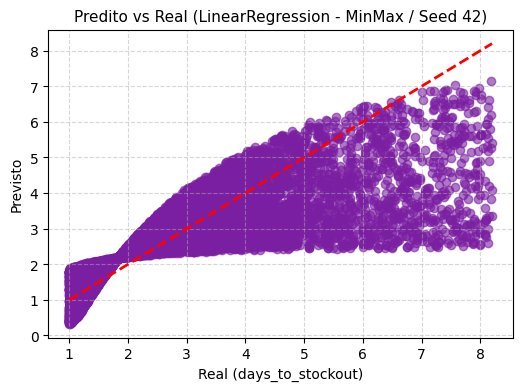


| Treinando Ridge...
| Ridge treinado! MAPE real: 22.31% | MAE real: 0.55 dias (22.84% da média)

| Amostra de valores reais vs previstos:


,Real (days_to_stockout),Previsto,Diferença (abs)
50684,2.160000,2.820000,0.650000
50685,1.830000,2.200000,0.370000
50686,2.590000,2.760000,0.170000
50687,1.150000,1.100000,0.040000
50688,1.300000,1.060000,0.240000
50689,1.720000,2.070000,0.350000
50690,4.980000,3.710000,1.270000
50691,6.470000,4.170000,2.300000
50692,2.190000,2.810000,0.620000
50693,1.780000,2.070000,0.290000


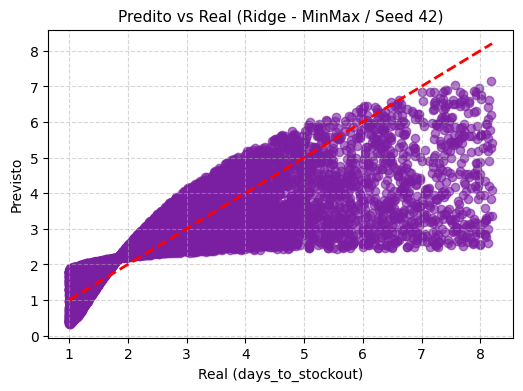


| Treinando RandomForest...
| RandomForest treinado! MAPE real: 0.32% | MAE real: 0.01 dias (0.38% da média)

| Amostra de valores reais vs previstos:


,Real (days_to_stockout),Previsto,Diferença (abs)
50684,2.160000,2.170000,0.010000
50685,1.830000,1.830000,0.000000
50686,2.590000,2.600000,0.000000
50687,1.150000,1.150000,0.000000
50688,1.300000,1.300000,0.000000
50689,1.720000,1.720000,0.000000
50690,4.980000,4.990000,0.010000
50691,6.470000,6.520000,0.050000
50692,2.190000,2.200000,0.010000
50693,1.780000,1.780000,0.000000


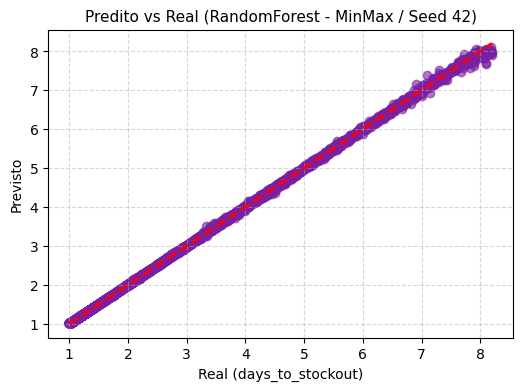


| Principais features:


,0
units_sold,0.649139
inventory_level,0.350638
units_ordered,0.000048
month,0.000035
dayofweek,0.000025



| Treinando XGBoost...
| XGBoost treinado! MAPE real: 4.27% | MAE real: 0.11 dias (4.75% da média)

| Amostra de valores reais vs previstos:


,Real (days_to_stockout),Previsto,Diferença (abs)
50684,2.160000,2.150000,0.020000
50685,1.830000,1.840000,0.000000
50686,2.590000,2.550000,0.040000
50687,1.150000,1.210000,0.070000
50688,1.300000,1.360000,0.060000
50689,1.720000,1.720000,0.000000
50690,4.980000,4.620000,0.360000
50691,6.470000,6.070000,0.400000
50692,2.190000,2.220000,0.020000
50693,1.780000,1.780000,0.000000


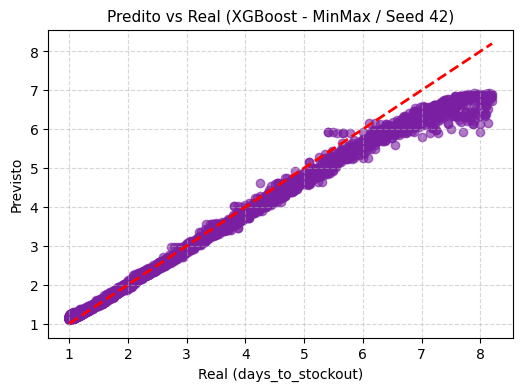


| Principais features:


,0
units_sold,0.651041
inventory_level,0.348959
units_ordered,0.000000
dayofweek,0.000000
month,0.000000



>>> Seed: 100

| Treinando LinearRegression...
| LinearRegression treinado! MAPE real: 22.31% | MAE real: 0.55 dias (22.84% da média)

| Amostra de valores reais vs previstos:


,Real (days_to_stockout),Previsto,Diferença (abs)
50684,2.160000,2.820000,0.660000
50685,1.830000,2.200000,0.370000
50686,2.590000,2.760000,0.170000
50687,1.150000,1.100000,0.040000
50688,1.300000,1.060000,0.240000
50689,1.720000,2.070000,0.350000
50690,4.980000,3.720000,1.260000
50691,6.470000,4.170000,2.290000
50692,2.190000,2.810000,0.620000
50693,1.780000,2.070000,0.290000


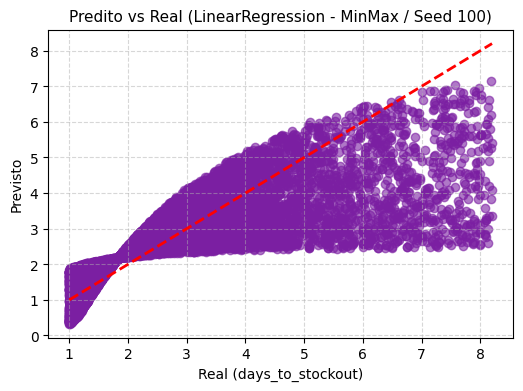


| Treinando Ridge...
| Ridge treinado! MAPE real: 22.31% | MAE real: 0.55 dias (22.84% da média)

| Amostra de valores reais vs previstos:


,Real (days_to_stockout),Previsto,Diferença (abs)
50684,2.160000,2.820000,0.650000
50685,1.830000,2.200000,0.370000
50686,2.590000,2.760000,0.170000
50687,1.150000,1.100000,0.040000
50688,1.300000,1.060000,0.240000
50689,1.720000,2.070000,0.350000
50690,4.980000,3.710000,1.270000
50691,6.470000,4.170000,2.300000
50692,2.190000,2.810000,0.620000
50693,1.780000,2.070000,0.290000


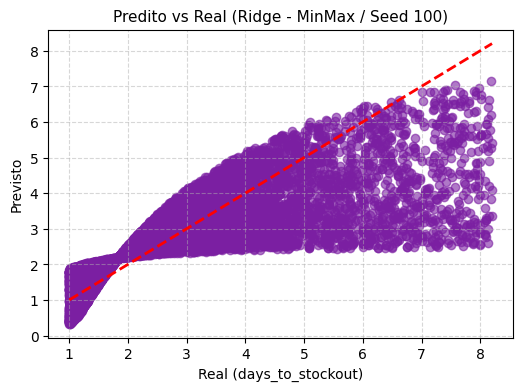


| Treinando RandomForest...
| RandomForest treinado! MAPE real: 0.32% | MAE real: 0.01 dias (0.37% da média)

| Amostra de valores reais vs previstos:


,Real (days_to_stockout),Previsto,Diferença (abs)
50684,2.160000,2.170000,0.000000
50685,1.830000,1.830000,0.000000
50686,2.590000,2.590000,0.000000
50687,1.150000,1.150000,0.000000
50688,1.300000,1.300000,0.000000
50689,1.720000,1.720000,0.000000
50690,4.980000,5.020000,0.040000
50691,6.470000,6.490000,0.030000
50692,2.190000,2.200000,0.010000
50693,1.780000,1.780000,0.000000


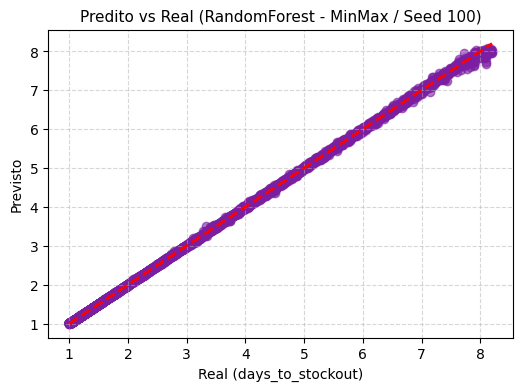


| Principais features:


,0
units_sold,0.650469
inventory_level,0.349307
units_ordered,0.000048
month,0.000035
dayofweek,0.000025



| Treinando XGBoost...
| XGBoost treinado! MAPE real: 4.27% | MAE real: 0.11 dias (4.75% da média)

| Amostra de valores reais vs previstos:


,Real (days_to_stockout),Previsto,Diferença (abs)
50684,2.160000,2.150000,0.020000
50685,1.830000,1.840000,0.000000
50686,2.590000,2.550000,0.040000
50687,1.150000,1.210000,0.070000
50688,1.300000,1.360000,0.060000
50689,1.720000,1.720000,0.000000
50690,4.980000,4.620000,0.360000
50691,6.470000,6.070000,0.400000
50692,2.190000,2.220000,0.020000
50693,1.780000,1.780000,0.000000


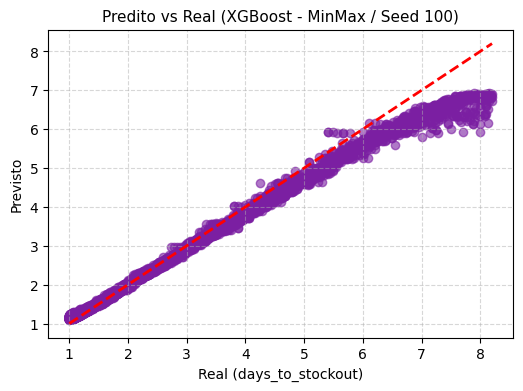


| Principais features:


,0
units_sold,0.651041
inventory_level,0.348959
units_ordered,0.000000
dayofweek,0.000000
month,0.000000



>>> Seed: 2025

| Treinando LinearRegression...
| LinearRegression treinado! MAPE real: 22.31% | MAE real: 0.55 dias (22.84% da média)

| Amostra de valores reais vs previstos:


,Real (days_to_stockout),Previsto,Diferença (abs)
50684,2.160000,2.820000,0.660000
50685,1.830000,2.200000,0.370000
50686,2.590000,2.760000,0.170000
50687,1.150000,1.100000,0.040000
50688,1.300000,1.060000,0.240000
50689,1.720000,2.070000,0.350000
50690,4.980000,3.720000,1.260000
50691,6.470000,4.170000,2.290000
50692,2.190000,2.810000,0.620000
50693,1.780000,2.070000,0.290000


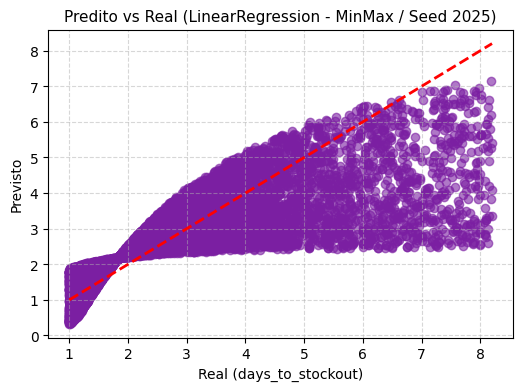


| Treinando Ridge...
| Ridge treinado! MAPE real: 22.31% | MAE real: 0.55 dias (22.84% da média)

| Amostra de valores reais vs previstos:


,Real (days_to_stockout),Previsto,Diferença (abs)
50684,2.160000,2.820000,0.650000
50685,1.830000,2.200000,0.370000
50686,2.590000,2.760000,0.170000
50687,1.150000,1.100000,0.040000
50688,1.300000,1.060000,0.240000
50689,1.720000,2.070000,0.350000
50690,4.980000,3.710000,1.270000
50691,6.470000,4.170000,2.300000
50692,2.190000,2.810000,0.620000
50693,1.780000,2.070000,0.290000


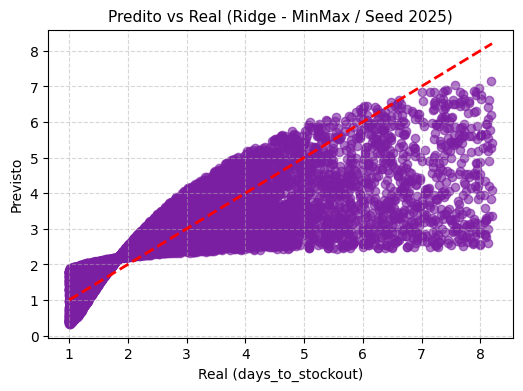


| Treinando RandomForest...
| RandomForest treinado! MAPE real: 0.32% | MAE real: 0.01 dias (0.38% da média)

| Amostra de valores reais vs previstos:


,Real (days_to_stockout),Previsto,Diferença (abs)
50684,2.160000,2.170000,0.000000
50685,1.830000,1.830000,0.000000
50686,2.590000,2.600000,0.000000
50687,1.150000,1.140000,0.000000
50688,1.300000,1.300000,0.000000
50689,1.720000,1.720000,0.000000
50690,4.980000,5.010000,0.030000
50691,6.470000,6.490000,0.030000
50692,2.190000,2.200000,0.000000
50693,1.780000,1.780000,0.000000


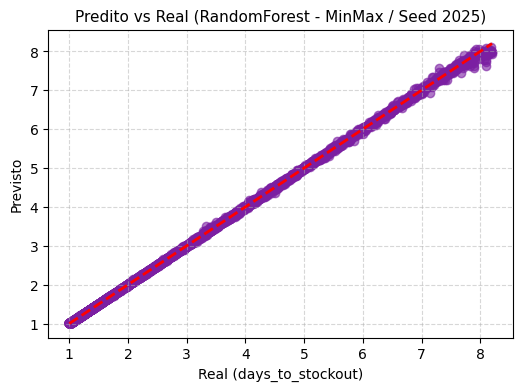


| Principais features:


,0
units_sold,0.645784
inventory_level,0.353994
units_ordered,0.000047
month,0.000035
dayofweek,0.000025



| Treinando XGBoost...
| XGBoost treinado! MAPE real: 4.27% | MAE real: 0.11 dias (4.75% da média)

| Amostra de valores reais vs previstos:


,Real (days_to_stockout),Previsto,Diferença (abs)
50684,2.160000,2.150000,0.020000
50685,1.830000,1.840000,0.000000
50686,2.590000,2.550000,0.040000
50687,1.150000,1.210000,0.070000
50688,1.300000,1.360000,0.060000
50689,1.720000,1.720000,0.000000
50690,4.980000,4.620000,0.360000
50691,6.470000,6.070000,0.400000
50692,2.190000,2.220000,0.020000
50693,1.780000,1.780000,0.000000


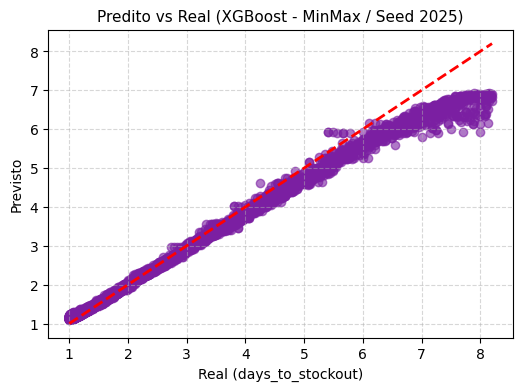


| Principais features:


,0
units_sold,0.651041
inventory_level,0.348959
units_ordered,0.000000
dayofweek,0.000000
month,0.000000



===== Dataset: Standard =====

>>> Seed: 42

| Treinando LinearRegression...
| LinearRegression treinado! MAPE real: 22.31% | MAE real: 0.55 dias (22.84% da média)

| Amostra de valores reais vs previstos:


,Real (days_to_stockout),Previsto,Diferença (abs)
50684,2.160000,2.820000,0.660000
50685,1.830000,2.200000,0.370000
50686,2.590000,2.760000,0.170000
50687,1.150000,1.100000,0.040000
50688,1.300000,1.060000,0.240000
50689,1.720000,2.070000,0.350000
50690,4.980000,3.720000,1.260000
50691,6.470000,4.170000,2.290000
50692,2.190000,2.810000,0.620000
50693,1.780000,2.070000,0.290000


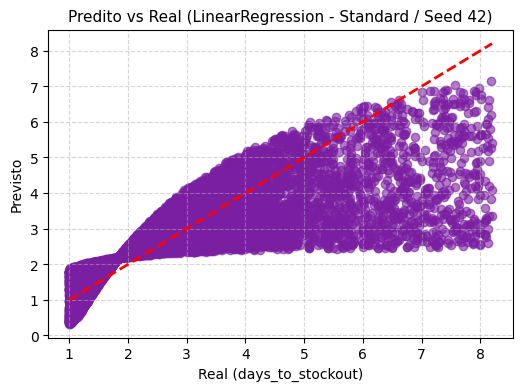


| Treinando Ridge...
| Ridge treinado! MAPE real: 22.31% | MAE real: 0.55 dias (22.84% da média)

| Amostra de valores reais vs previstos:


,Real (days_to_stockout),Previsto,Diferença (abs)
50684,2.160000,2.820000,0.660000
50685,1.830000,2.200000,0.370000
50686,2.590000,2.760000,0.170000
50687,1.150000,1.100000,0.040000
50688,1.300000,1.060000,0.240000
50689,1.720000,2.070000,0.350000
50690,4.980000,3.720000,1.260000
50691,6.470000,4.170000,2.290000
50692,2.190000,2.810000,0.620000
50693,1.780000,2.070000,0.290000


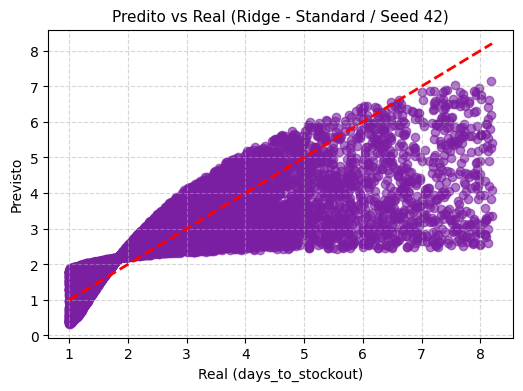


| Treinando RandomForest...
| RandomForest treinado! MAPE real: 0.32% | MAE real: 0.01 dias (0.38% da média)

| Amostra de valores reais vs previstos:


,Real (days_to_stockout),Previsto,Diferença (abs)
50684,2.160000,2.170000,0.010000
50685,1.830000,1.840000,0.000000
50686,2.590000,2.600000,0.000000
50687,1.150000,1.150000,0.000000
50688,1.300000,1.300000,0.000000
50689,1.720000,1.720000,0.000000
50690,4.980000,4.990000,0.010000
50691,6.470000,6.520000,0.060000
50692,2.190000,2.200000,0.010000
50693,1.780000,1.780000,0.000000


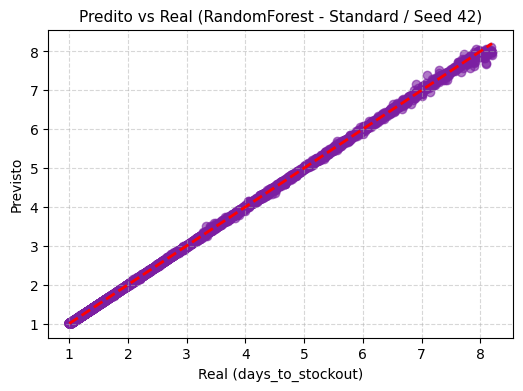


| Principais features:


,0
units_sold,0.649139
inventory_level,0.350638
units_ordered,0.000048
month,0.000035
dayofweek,0.000025



| Treinando XGBoost...
| XGBoost treinado! MAPE real: 4.27% | MAE real: 0.11 dias (4.75% da média)

| Amostra de valores reais vs previstos:


,Real (days_to_stockout),Previsto,Diferença (abs)
50684,2.160000,2.150000,0.020000
50685,1.830000,1.840000,0.000000
50686,2.590000,2.550000,0.040000
50687,1.150000,1.210000,0.070000
50688,1.300000,1.360000,0.060000
50689,1.720000,1.720000,0.000000
50690,4.980000,4.620000,0.360000
50691,6.470000,6.070000,0.400000
50692,2.190000,2.220000,0.020000
50693,1.780000,1.780000,0.000000


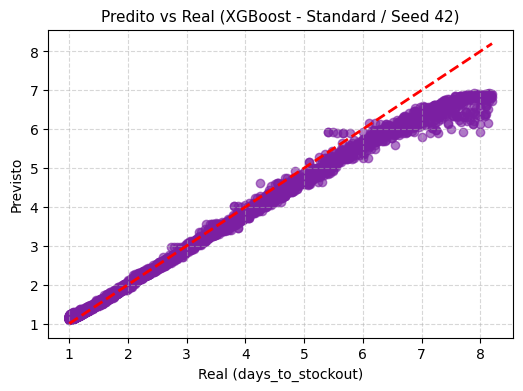


| Principais features:


,0
units_sold,0.651041
inventory_level,0.348959
units_ordered,0.000000
dayofweek,0.000000
month,0.000000



>>> Seed: 100

| Treinando LinearRegression...
| LinearRegression treinado! MAPE real: 22.31% | MAE real: 0.55 dias (22.84% da média)

| Amostra de valores reais vs previstos:


,Real (days_to_stockout),Previsto,Diferença (abs)
50684,2.160000,2.820000,0.660000
50685,1.830000,2.200000,0.370000
50686,2.590000,2.760000,0.170000
50687,1.150000,1.100000,0.040000
50688,1.300000,1.060000,0.240000
50689,1.720000,2.070000,0.350000
50690,4.980000,3.720000,1.260000
50691,6.470000,4.170000,2.290000
50692,2.190000,2.810000,0.620000
50693,1.780000,2.070000,0.290000


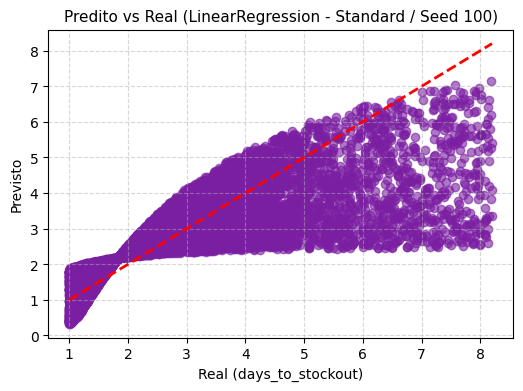


| Treinando Ridge...
| Ridge treinado! MAPE real: 22.31% | MAE real: 0.55 dias (22.84% da média)

| Amostra de valores reais vs previstos:


,Real (days_to_stockout),Previsto,Diferença (abs)
50684,2.160000,2.820000,0.660000
50685,1.830000,2.200000,0.370000
50686,2.590000,2.760000,0.170000
50687,1.150000,1.100000,0.040000
50688,1.300000,1.060000,0.240000
50689,1.720000,2.070000,0.350000
50690,4.980000,3.720000,1.260000
50691,6.470000,4.170000,2.290000
50692,2.190000,2.810000,0.620000
50693,1.780000,2.070000,0.290000


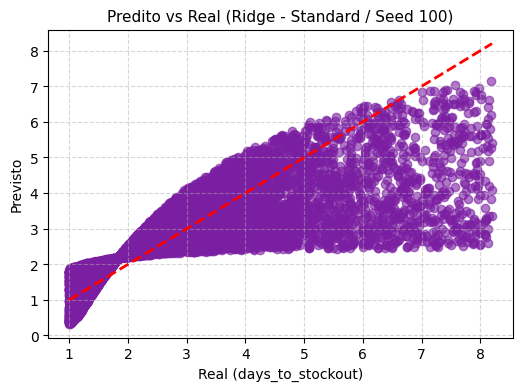


| Treinando RandomForest...
| RandomForest treinado! MAPE real: 0.32% | MAE real: 0.01 dias (0.38% da média)

| Amostra de valores reais vs previstos:


,Real (days_to_stockout),Previsto,Diferença (abs)
50684,2.160000,2.170000,0.000000
50685,1.830000,1.830000,0.000000
50686,2.590000,2.590000,0.000000
50687,1.150000,1.150000,0.000000
50688,1.300000,1.300000,0.000000
50689,1.720000,1.720000,0.000000
50690,4.980000,5.020000,0.040000
50691,6.470000,6.490000,0.030000
50692,2.190000,2.200000,0.010000
50693,1.780000,1.780000,0.000000


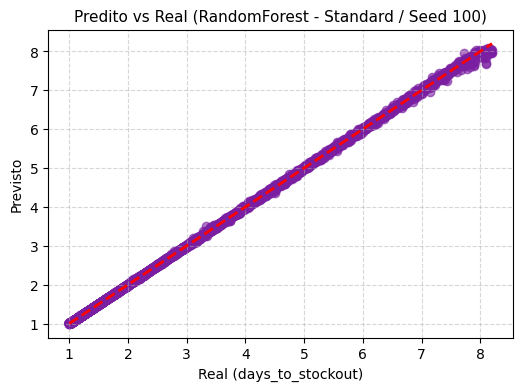


| Principais features:


,0
units_sold,0.650469
inventory_level,0.349307
units_ordered,0.000048
month,0.000035
dayofweek,0.000025



| Treinando XGBoost...
| XGBoost treinado! MAPE real: 4.27% | MAE real: 0.11 dias (4.75% da média)

| Amostra de valores reais vs previstos:


,Real (days_to_stockout),Previsto,Diferença (abs)
50684,2.160000,2.150000,0.020000
50685,1.830000,1.840000,0.000000
50686,2.590000,2.550000,0.040000
50687,1.150000,1.210000,0.070000
50688,1.300000,1.360000,0.060000
50689,1.720000,1.720000,0.000000
50690,4.980000,4.620000,0.360000
50691,6.470000,6.070000,0.400000
50692,2.190000,2.220000,0.020000
50693,1.780000,1.780000,0.000000


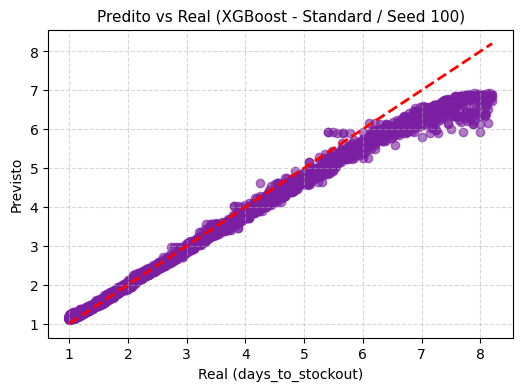


| Principais features:


,0
units_sold,0.651041
inventory_level,0.348959
units_ordered,0.000000
dayofweek,0.000000
month,0.000000



>>> Seed: 2025

| Treinando LinearRegression...
| LinearRegression treinado! MAPE real: 22.31% | MAE real: 0.55 dias (22.84% da média)

| Amostra de valores reais vs previstos:


,Real (days_to_stockout),Previsto,Diferença (abs)
50684,2.160000,2.820000,0.660000
50685,1.830000,2.200000,0.370000
50686,2.590000,2.760000,0.170000
50687,1.150000,1.100000,0.040000
50688,1.300000,1.060000,0.240000
50689,1.720000,2.070000,0.350000
50690,4.980000,3.720000,1.260000
50691,6.470000,4.170000,2.290000
50692,2.190000,2.810000,0.620000
50693,1.780000,2.070000,0.290000


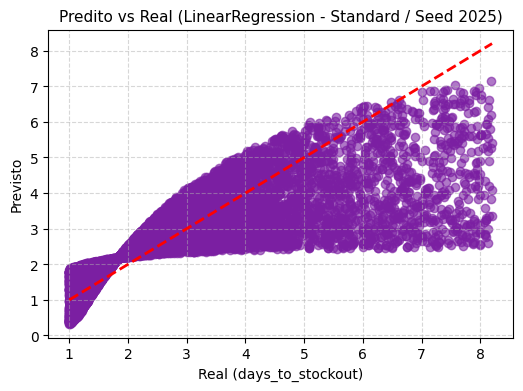


| Treinando Ridge...
| Ridge treinado! MAPE real: 22.31% | MAE real: 0.55 dias (22.84% da média)

| Amostra de valores reais vs previstos:


,Real (days_to_stockout),Previsto,Diferença (abs)
50684,2.160000,2.820000,0.660000
50685,1.830000,2.200000,0.370000
50686,2.590000,2.760000,0.170000
50687,1.150000,1.100000,0.040000
50688,1.300000,1.060000,0.240000
50689,1.720000,2.070000,0.350000
50690,4.980000,3.720000,1.260000
50691,6.470000,4.170000,2.290000
50692,2.190000,2.810000,0.620000
50693,1.780000,2.070000,0.290000


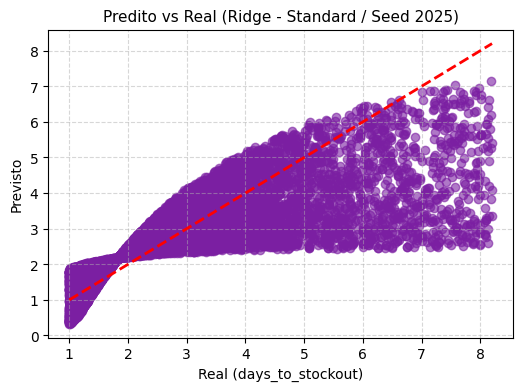


| Treinando RandomForest...
| RandomForest treinado! MAPE real: 0.32% | MAE real: 0.01 dias (0.38% da média)

| Amostra de valores reais vs previstos:


,Real (days_to_stockout),Previsto,Diferença (abs)
50684,2.160000,2.170000,0.000000
50685,1.830000,1.830000,0.000000
50686,2.590000,2.600000,0.010000
50687,1.150000,1.140000,0.000000
50688,1.300000,1.300000,0.000000
50689,1.720000,1.720000,0.000000
50690,4.980000,5.010000,0.030000
50691,6.470000,6.500000,0.040000
50692,2.190000,2.200000,0.000000
50693,1.780000,1.780000,0.000000


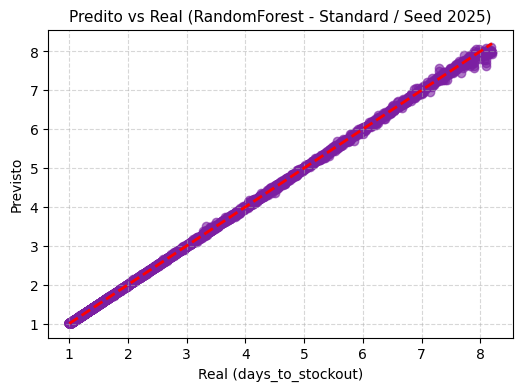


| Principais features:


,0
units_sold,0.645784
inventory_level,0.353994
units_ordered,0.000047
month,0.000035
dayofweek,0.000025



| Treinando XGBoost...
| XGBoost treinado! MAPE real: 4.27% | MAE real: 0.11 dias (4.75% da média)

| Amostra de valores reais vs previstos:


,Real (days_to_stockout),Previsto,Diferença (abs)
50684,2.160000,2.150000,0.020000
50685,1.830000,1.840000,0.000000
50686,2.590000,2.550000,0.040000
50687,1.150000,1.210000,0.070000
50688,1.300000,1.360000,0.060000
50689,1.720000,1.720000,0.000000
50690,4.980000,4.620000,0.360000
50691,6.470000,6.070000,0.400000
50692,2.190000,2.220000,0.020000
50693,1.780000,1.780000,0.000000


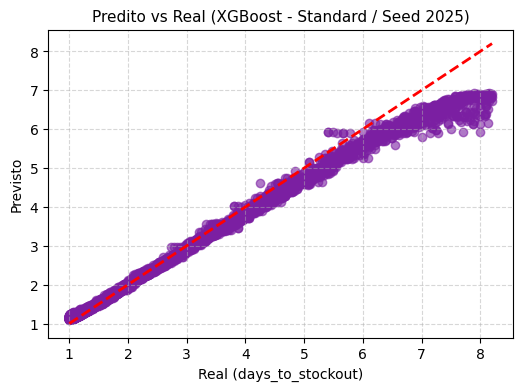


| Principais features:


,0
units_sold,0.651041
inventory_level,0.348959
units_ordered,0.000000
dayofweek,0.000000
month,0.000000


In [43]:
# Seeds e modelos
seeds = [42, 100, 2025]
models_def = {
    "LinearRegression": lambda seed=None: LinearRegression(),
    "Ridge": lambda seed=None: Ridge(alpha=1.0),
    "RandomForest": lambda seed: RandomForestRegressor(n_estimators=50, random_state=seed, n_jobs=-1),
    "XGBoost": lambda seed: XGBRegressor(n_estimators=50, learning_rate=0.05, random_state=seed, n_jobs=-1)
}

all_results = {}
models = {}
datasets_test = {}

# Loop pelos datasets já pré-processados
datasets_clean = {
    "MinMax": df_minmax,
    "Standard": df_std
}

for ds_name, df in datasets_clean.items():
    print(f"\n===== Dataset: {ds_name} =====")
    
    X = df.drop(columns=['days_to_stockout_log'], errors='ignore')
    y = df['days_to_stockout_log']
    
    for seed in seeds:
        print(f"\n>>> Seed: {seed}")
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
        
        for name, model_func in models_def.items():
            model = model_func(seed)
            print(f"\n| Treinando {name}...")

            start_train = time.time()
            model.fit(X_train, y_train)
            end_train = time.time()
            
            start_pred = time.time()
            y_pred = model.predict(X_test)
            end_pred = time.time()
            
            # Métricas básicas
            y_test_real = np.expm1(y_test)
            y_pred_real = np.expm1(y_pred)
            
            mae_real = mean_absolute_error(y_test_real, y_pred_real)
            mape_real = np.mean(np.abs((y_test_real - y_pred_real) / y_test_real)) * 100
            mae_rel_real = (mae_real / y_test_real.mean()) * 100
            
            # Salvar resultados básicos
            all_results[(ds_name, seed, name)] = {
                'MAPE_log': mean_absolute_percentage_error_safe(y_test, y_pred),
                'MAPE_real': mape_real,
                'MAE_real': mae_real,
                'MAE_rel_real_%': mae_rel_real,
                'Treino_s': end_train - start_train,
                'Predicao_s': end_pred - start_pred
            }
            
            # Salvar modelo e dados de teste para avaliação posterior
            models[(ds_name, seed, name)] = model
            datasets_test[(ds_name, seed, name)] = {
                'X_test': X_test,
                'y_test': y_test,
                'y_pred': y_pred,
                'y_test_real': y_test_real,
                'y_pred_real': y_pred_real
            }
            
            print(f"| {name} treinado! MAPE real: {mape_real:.2f}% | MAE real: {mae_real:.2f} dias ({mae_rel_real:.2f}% da média)")
            
            # === Comparação dos valores reais e previstos ===
            comparacao = pd.DataFrame({
                'Real (days_to_stockout)': y_test_real.round(2),
                'Previsto': y_pred_real.round(2),
                'Diferença (abs)': abs(y_test_real - y_pred_real).round(2)
            })
            print("\n| Amostra de valores reais vs previstos:")
            display(comparacao.head(10).style.set_table_styles([
                {'selector': 'th', 'props': [('background-color', '#4B0055'), ('color', 'white')]},
                {'selector': 'td', 'props': [('padding', '4px')] }
            ]))
            
            # === Gráfico Predito vs Real ===
            plt.figure(figsize=(6, 4))
            plt.scatter(y_test_real, y_pred_real, alpha=0.6, color="#7B1FA2")
            plt.plot([y_test_real.min(), y_test_real.max()],
                     [y_test_real.min(), y_test_real.max()],
                     'r--', lw=2)
            plt.title(f"Predito vs Real ({name} - {ds_name} / Seed {seed})", fontsize=11)
            plt.xlabel("Real (days_to_stockout)")
            plt.ylabel("Previsto")
            plt.grid(True, linestyle='--', alpha=0.5)
            plt.show()
            
            # === Importância das features (se disponível) ===
            if hasattr(model, "feature_importances_"):
                feat_imp = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
                print("\n| Principais features:")
                display(feat_imp.head(5).to_frame().style.set_table_styles([
                    {'selector': 'th', 'props': [('background-color', '#FFA726'), ('color', 'white')]},
                    {'selector': 'td', 'props': [('padding', '5px')]}
                ]))


<!-- Etapa 6 -->
<div style="background:#F7F3FF; border-left:8px solid #FFA726; padding:18px; border-radius:10px; margin-top:24px; width: 97%">
  <span style="font-size:1.2em; color:#4B0055; font-weight:bold;">6. Avaliação do Modelo</span>
  <ul style="color:#4B0055; margin-top:12px;">
    <li>Métricas principais: MAE, MAPE, R², MSE e RMSE</li>
    <li>Comparar resultados entre os modelos treinados</li>
    <li>Visualizar predição vs valores reais para identificar erros sistemáticos</li>
  </ul>
</div>

In [44]:
# Avaliação completa
for key, model in models.items():
    ds_name, seed, name = key
    X_test = datasets_test[key]['X_test']
    y_test_real = datasets_test[key]['y_test_real']
    y_pred_real = datasets_test[key]['y_pred_real']
    
    mae = mean_absolute_error(y_test_real, y_pred_real)
    mae_rel = (mae / y_test_real.mean()) * 100
    mape = np.mean(np.abs((y_test_real - y_pred_real) / y_test_real)) * 100
    mse = mean_squared_error(y_test_real, y_pred_real)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_real, y_pred_real)
    
    print(f"\n📊 | {name} | Dataset: {ds_name} | Seed: {seed}")
    print(f"   MAE: {mae:.3f} dias ({mae_rel:.2f}% da média real)")
    print(f"   MAPE: {mape:.2f}% | MSE: {mse:.3f} | RMSE: {rmse:.3f} | R²: {r2:.3f}")



📊 | LinearRegression | Dataset: MinMax | Seed: 42
   MAE: 0.553 dias (22.84% da média real)
   MAPE: 22.31% | MSE: 0.788 | RMSE: 0.888 | R²: 0.678

📊 | Ridge | Dataset: MinMax | Seed: 42
   MAE: 0.553 dias (22.84% da média real)
   MAPE: 22.31% | MSE: 0.789 | RMSE: 0.888 | R²: 0.677

📊 | RandomForest | Dataset: MinMax | Seed: 42
   MAE: 0.009 dias (0.38% da média real)
   MAPE: 0.32% | MSE: 0.000 | RMSE: 0.020 | R²: 1.000

📊 | XGBoost | Dataset: MinMax | Seed: 42
   MAE: 0.115 dias (4.75% da média real)
   MAPE: 4.27% | MSE: 0.046 | RMSE: 0.214 | R²: 0.981

📊 | LinearRegression | Dataset: MinMax | Seed: 100
   MAE: 0.553 dias (22.84% da média real)
   MAPE: 22.31% | MSE: 0.788 | RMSE: 0.888 | R²: 0.678

📊 | Ridge | Dataset: MinMax | Seed: 100
   MAE: 0.553 dias (22.84% da média real)
   MAPE: 22.31% | MSE: 0.789 | RMSE: 0.888 | R²: 0.677

📊 | RandomForest | Dataset: MinMax | Seed: 100
   MAE: 0.009 dias (0.37% da média real)
   MAPE: 0.32% | MSE: 0.000 | RMSE: 0.019 | R²: 1.000

📊 | X

<!-- Etapa 7 -->
<div style="background:#F7F3FF; border-left:8px solid #FFA726; padding:18px; border-radius:10px; margin-top:24px; width: 97%">
  <span style="font-size:1.2em; color:#4B0055; font-weight:bold;">7. Seleção do Melhor Modelo</span>
  <ul style="color:#4B0055; margin-top:12px;">
    <li>Comparar métricas de todos os modelos treinados</li>
    <li>Selecionar o modelo com menor MAPE/RMSE e boa interpretação</li>
    <li>Salvar modelo final para deploy</li>
  </ul>
</div>

In [45]:
import joblib

# 1) Criar um DataFrame com os resultados de todos os modelos
resumo = []

for key, model in models.items():
    ds_name, seed, name = key
    X_test = datasets_test[key]['X_test']
    y_test_real = datasets_test[key]['y_test_real']
    y_pred_real = datasets_test[key]['y_pred_real']

    mae = mean_absolute_error(y_test_real, y_pred_real)
    mae_rel = (mae / y_test_real.mean()) * 100
    mape = np.mean(np.abs((y_test_real - y_pred_real) / y_test_real)) * 100
    mse = mean_squared_error(y_test_real, y_pred_real)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_real, y_pred_real)

    resumo.append({
        'Dataset': ds_name,
        'Seed': seed,
        'Modelo': name,
        'MAE': mae,
        'MAE_rel_%': mae_rel,
        'MAPE_%': mape,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2
    })

df_resumo = pd.DataFrame(resumo)
df_resumo_sorted = df_resumo.sort_values('RMSE')
display(df_resumo_sorted.style.set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#4B0055'), ('color', 'white')]},
    {'selector': 'td', 'props': [('padding', '4px')]}
]).format({
    'MAE': "{:.3f}",
    'MAE_rel_%': "{:.2f}%",
    'MAPE_%': "{:.2f}%",
    'MSE': "{:.3f}",
    'RMSE': "{:.3f}",
    'R2': "{:.3f}"
}))

# 2) Selecionar o modelo com menor RMSE
melhor_linha = df_resumo.loc[df_resumo['RMSE'].idxmin()]
melhor_key = (melhor_linha['Dataset'], melhor_linha['Seed'], melhor_linha['Modelo'])
melhor_modelo = models[melhor_key]

print("\n🏆 Melhor modelo selecionado:")
print(melhor_linha)

# 3) Salvar modelo final para deploy
joblib.dump(melhor_modelo, 'modelo_final_fluxar.pkl')
print("\nModelo salvo em 'modelo_final_fluxar.pkl'")


,Dataset,Seed,Modelo,MAE,MAE_rel_%,MAPE_%,MSE,RMSE,R2
6,MinMax,100,RandomForest,0.009,0.37%,0.32%,0.000,0.019,1.000
18,Standard,100,RandomForest,0.009,0.38%,0.32%,0.000,0.019,1.000
2,MinMax,42,RandomForest,0.009,0.38%,0.32%,0.000,0.020,1.000
14,Standard,42,RandomForest,0.009,0.38%,0.32%,0.000,0.020,1.000
10,MinMax,2025,RandomForest,0.009,0.38%,0.32%,0.000,0.020,1.000
22,Standard,2025,RandomForest,0.009,0.38%,0.32%,0.000,0.020,1.000
11,MinMax,2025,XGBoost,0.115,4.75%,4.27%,0.046,0.214,0.981
15,Standard,42,XGBoost,0.115,4.75%,4.27%,0.046,0.214,0.981
19,Standard,100,XGBoost,0.115,4.75%,4.27%,0.046,0.214,0.981
23,Standard,2025,XGBoost,0.115,4.75%,4.27%,0.046,0.214,0.981



🏆 Melhor modelo selecionado:
Dataset            MinMax
Seed                  100
Modelo       RandomForest
MAE              0.009049
MAE_rel_%        0.373975
MAPE_%           0.316412
MSE               0.00037
RMSE             0.019239
R2               0.999849
Name: 6, dtype: object

Modelo salvo em 'modelo_final_fluxar.pkl'


<!-- Etapa 8 -->
<div style="background:#F7F3FF; border-left:8px solid #FFA726; padding:18px; border-radius:10px; margin-top:24px; width: 97%">
  <span style="font-size:1.2em; color:#4B0055; font-weight:bold;">8. Salvamento do Modelo no Redis</span>
  <ul style="color:#4B0055; margin-top:12px;">
    <li>Serializar o modelo final usando <code>joblib</code> em memória (BytesIO)</li>
    <li>Salvar os bytes do modelo em uma chave no Redis</li>
    <li>Carregar o modelo do Redis para realizar predições em tempo real</li>
  </ul>

In [46]:
# Conectar ao Redis (sem decode_responses)
r = redis.Redis(host='localhost', port=6379, db=0)

# Serializar modelo em memória
model_bytes = io.BytesIO()
joblib.dump(melhor_modelo, model_bytes)
model_bytes.seek(0)

# Salvar no Redis
r.set('ml_model_fluxar', model_bytes.read())
print("Modelo salvo no Redis com a chave 'ml_model_fluxar'")

# Carregar modelo do Redis
model_data = r.get('ml_model_fluxar')
model_loaded = joblib.load(io.BytesIO(model_data))

# Testar predição com a primeira amostra de X_test
X_test_example = datasets_test[melhor_key]['X_test']
prediction = model_loaded.predict(X_test_example.iloc[0:1])
print(f"Predição de exemplo: {prediction[0]}")

Modelo salvo no Redis com a chave 'ml_model_fluxar'
Predição de exemplo: 1.1529669840375099
